Welcome to aasignment 1.                                                       

We are using pathology images for our first assignment please download data from this link https://drive.google.com/drive/folders/10dUOzcPR-PQwfFYcHk5gsLjIjSorQ32Q?usp=sharing



### Task 1: Feature Generation (15%)
Use and run the following code (a deep network) to generate features from a set of training images. For this assignment, you do not need to know how the deep network is working here to extract features.
This code extracts the features of image T4.tif (in the T folder of dataset). Modify the code so that it iterates over all images of the dataset and extracts their features.
Allocate 10% of the data for validation.

Insert your code here for Task 1





In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.models import densenet121
from torch.autograd import Variable
from PIL import Image
import os
import numpy as np
# Load pre-trained DenseNet model
model = densenet121(pretrained=True)

# Remove the classification layer (last fully connected layer)
model = torch.nn.Sequential(*list(model.children())[:-1])

# Add a global average pooling layer
model.add_module('global_avg_pool', torch.nn.AdaptiveAvgPool2d(1))

# Set the model to evaluation mode
model.eval()

# Define the image preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Path to the "train" folder
train_folder = "train"

train_labels = []
train_feature_vectors = []


# Iterate over all the folders and files in the "train" folder
for root, dirs, files in os.walk(train_folder):
    for file in files:
        # Get the image path
        image_path = os.path.join(root, file)
        
        # Load an image 
        image = Image.open(image_path)

        # get class label from root
        label = root.split("\\")[1]
        train_labels.append(float((ord(label) - ord('A')))) # convert chars into numbers where A -> 0

        # Preprocess the image
        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

        # Wrap the input tensor in a Variable
        input_var = Variable(input_batch)

        # Forward pass through the model
        features = model(input_var)

        # Extract the feature tensor
        feature_vector = features.squeeze().detach().numpy()
        train_feature_vectors.append(feature_vector)

train_feature_vectors = np.array(train_feature_vectors)
train_labels = np.array(train_labels)


c:\Users\Cooper\miniconda3\envs\syde522\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Cooper\miniconda3\envs\syde522\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Task 1 Cont'd
Validation Data

In [3]:
import os
# Path to the "validate" folder
validate_folder = "validate"

# Initialize empty lists for the validation data
validate_feature_vectors = []
validate_labels = []

# Iterate over all the folders and files in the "validate" folder
for root, dirs, files in os.walk(validate_folder):
    for file in files:
        # Get the image path
        image_path = os.path.join(root, file)
        
        # Load an image 
        image = Image.open(image_path)


        # Preprocess the image
        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

        # Wrap the input tensor in a Variable
        input_var = Variable(input_batch)

        # Forward pass through the model
        features = model(input_var)

        # Extract the feature tensor
        feature_vector = features.squeeze().detach().numpy()

        # Append the feature vector and label to the validation lists
        validate_feature_vectors.append(feature_vector)
        
        # get class label from root
        label = root.split("\\")[1]
        validate_labels.append(float((ord(label) - ord('A')))) # convert chars into numbers where A -> 0

validate_feature_vectors = np.array(validate_feature_vectors)
validate_labels = np.array(validate_labels)

# Task 2: High Bias Classification Method (5%)
Choose a classification method and let is have a high bias.
Train it on the generated features and discuss why it is underfitting.

Insert your code here for Task 2




Accuracy: -0.008241702634152137


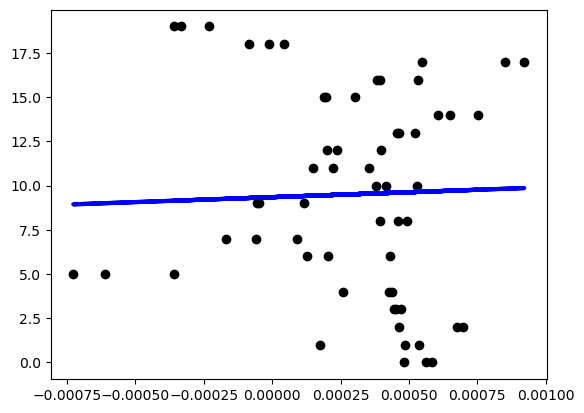

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split the data into training and validation sets and only select first feature for high bias
biased_X_train = train_feature_vectors[:, :1]
y_train = train_labels
biased_X_val = validate_feature_vectors[:, :1]
y_val = validate_labels

# Create a linear regression model with high bias
clf = LinearRegression()

# Train the model on the training data
clf.fit(biased_X_train, y_train)

# prediction for plotting
pred_values = clf.predict(biased_X_val) 

# Evaluate the model on the validation data
accuracy = clf.score(biased_X_val, y_val)
print("Accuracy:", accuracy)

plt.scatter(biased_X_val, y_val, color="black")
plt.plot(biased_X_val, pred_values, color="blue", linewidth=3)

plt.show()


# Task 3: High Variance Classification Method (5%)
Use the chosen classification method and let it have a high variance.
Train it on the generated features and discuss why it is overfitting.

Insert your code here for Task 3




Accuracy: 0.8747197638265239


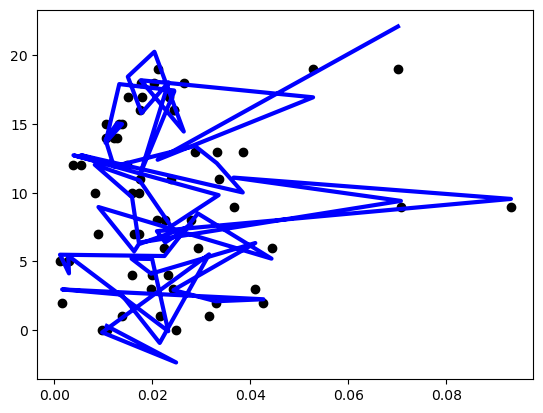

In [7]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial features up to a higher degree
poly = PolynomialFeatures(degree=2) # Higher degree polynomial

X_train_expanded = poly.fit_transform(train_feature_vectors)
X_val_expanded = poly.transform(validate_feature_vectors)

# Create a linear regression model with high variance
clf = LinearRegression()

# Train the model on the training data
clf.fit(X_train_expanded, y_train)

# prediction for plotting
train_pred = clf.predict(X_val_expanded)

# Evaluate the model on the validation data
accuracy = clf.score(X_val_expanded, y_val)
X_val_expanded = np.mean(X_val_expanded, axis=1).reshape(-1, 1)

print("Accuracy:", accuracy)

plt.scatter(X_val_expanded, y_val, color="black")
plt.plot(X_val_expanded, train_pred, color="blue", linewidth=3)

plt.show()

# Task 4: Balanced Classification Method (15%)
Use the chosen classification method and let it balance the bias and variance.
Train it on the generated features, possibly adjusting parameters.
Discuss insights into achieving balance.

Insert your code here for Task 4




Accuracy: 0.9060979554028832


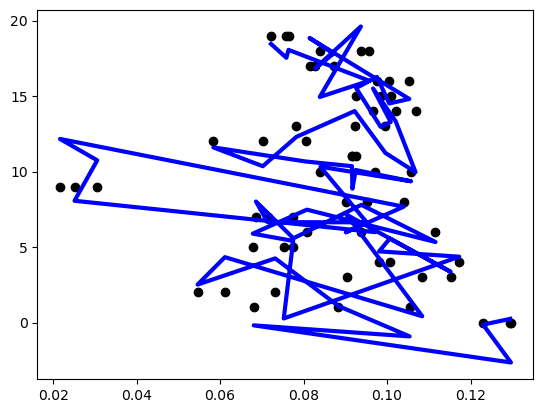

In [8]:
y_train = train_labels
y_val = validate_labels
balanced_val = validate_feature_vectors[:, :250]
balanced_train = train_feature_vectors[:, :250]

# Create a linear regression model with high bias
clf = LinearRegression()

# Train the model on the training data
clf.fit(balanced_train, y_train)

# prediction for plotting
pred_values = clf.predict(balanced_val) 

# Evaluate the model on the validation data
accuracy = clf.score(balanced_val, y_val)
print("Accuracy:", accuracy)

# balanced_val.reshape(-1, 1)
# balanced_val.resize((60,))

balanced_val = np.mean(balanced_val, axis=1).reshape(-1, 1)

plt.scatter(balanced_val, y_val, color="black")
plt.plot(balanced_val, pred_values, color="blue", linewidth=3)

plt.show()

# Task 5: K-Means Clustering (20%)
Apply K-Means clustering on the generated features.
Test with available labels and report accuracy.
Experiment with automated K and compare with manually set 20 clusters.

Insert your code here for Task 5




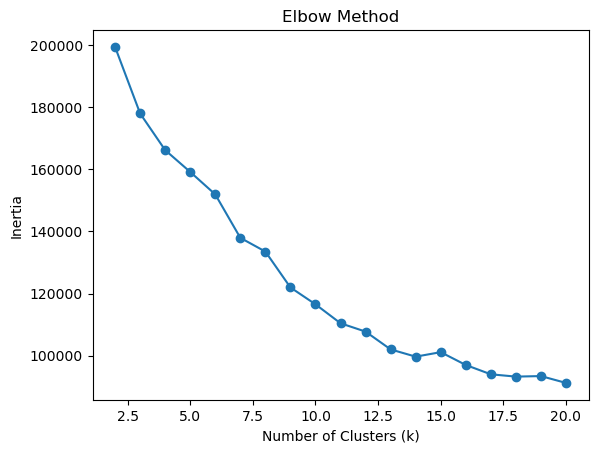

Manual Accuracy: 0.04027777777777778
Auto Accuracy: 0.10138888888888889


In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import os
import matplotlib.pyplot as plt

os.environ['OMP_NUM_THREADS'] = '3'

## Manual select k
# Set the number of clusters
k_manual = 20

# Create a KMeans object
kmeans_manual = KMeans(n_clusters=k_manual)

# Fit the KMeans model to the training data
kmeans_manual.fit(train_feature_vectors)

# Get the cluster labels for each data point
train_kmeansManualCluster_labels = kmeans_manual.labels_

## Auto select k
# Define a range of possible values for k
k_values_auto = range(2, 21)

# Initialize an empty list to store the inertia values
inertia_values = []

# Iterate over each value of k
for k in k_values_auto:
    # Create a KMeans object
    kmeans_auto = KMeans(n_clusters=k)
    
    # Fit the KMeans model to the training data
    kmeans_auto.fit(train_feature_vectors)
    
    # Get the inertia value (sum of squared distances to the nearest centroid) for the model
    inertia = kmeans_auto.inertia_
    
    # Append the inertia value to the list
    inertia_values.append(inertia)

# Plot the inertia values against the number of clusters
plt.plot(k_values_auto, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Select the elbow point as the best value for k
k_auto = 10
# Create a KMeans object
kmeans_auto = KMeans(n_clusters=k_auto)
# Fit the KMeans model to the training data
kmeans_auto.fit(train_feature_vectors)
# Get the cluster labels for each data point
train_kmeansAutoCluster_labels = kmeans_auto.labels_


# Calculate the accuracies
accuracy_manual = accuracy_score(train_labels, train_kmeansManualCluster_labels)
accuracy_auto = accuracy_score(train_labels, train_kmeansAutoCluster_labels)
# Print the accuracies
print("Manual Accuracy:", accuracy_manual)
print("Auto Accuracy:", accuracy_auto)


# Task 6: Additional Clustering Algorithm (10%)
Choose another clustering algorithm and apply it on the features.
Test accuracy with available labels.

Insert your code here for Task 6




# Task 7: PCA for Classification Improvement (20%)
Apply PCA on the features and then feed them to the best classification method in the above tasks.
Assess if PCA improves outcomes and discuss the results.

Insert your code here for Task 7




# Task 8: Visualization and Analysis (10%)
Plot the features in a lower dimension using dimentinality reduction techniques.
Analyze the visual representation, identifying patterns or insights.

Insert your code here for Task 8